In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import warnings
import numpy as np

In [2]:
test = pd.read_csv('NB15_testing-set.csv')
train = pd.read_csv('NB15_training-set.csv')
feature_desc = pd.read_csv('NB15_features.csv', encoding='cp1252')

print(train.columns.tolist())

train

['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


C:\Users\zalak\AppData\Local\Temp\ipykernel_21872\221933258.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))
C:\Users\zalak\AppData\Local\Temp\ipykernel_21872\221933258.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_encoded[column] = le.fit_transform(test_encoded[column].astype(str))


(175341,)


C:\Users\zalak\AppData\Local\Temp\ipykernel_21872\221933258.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  u.set_xticklabels(u.get_xticklabels(),rotation=90)


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5')]

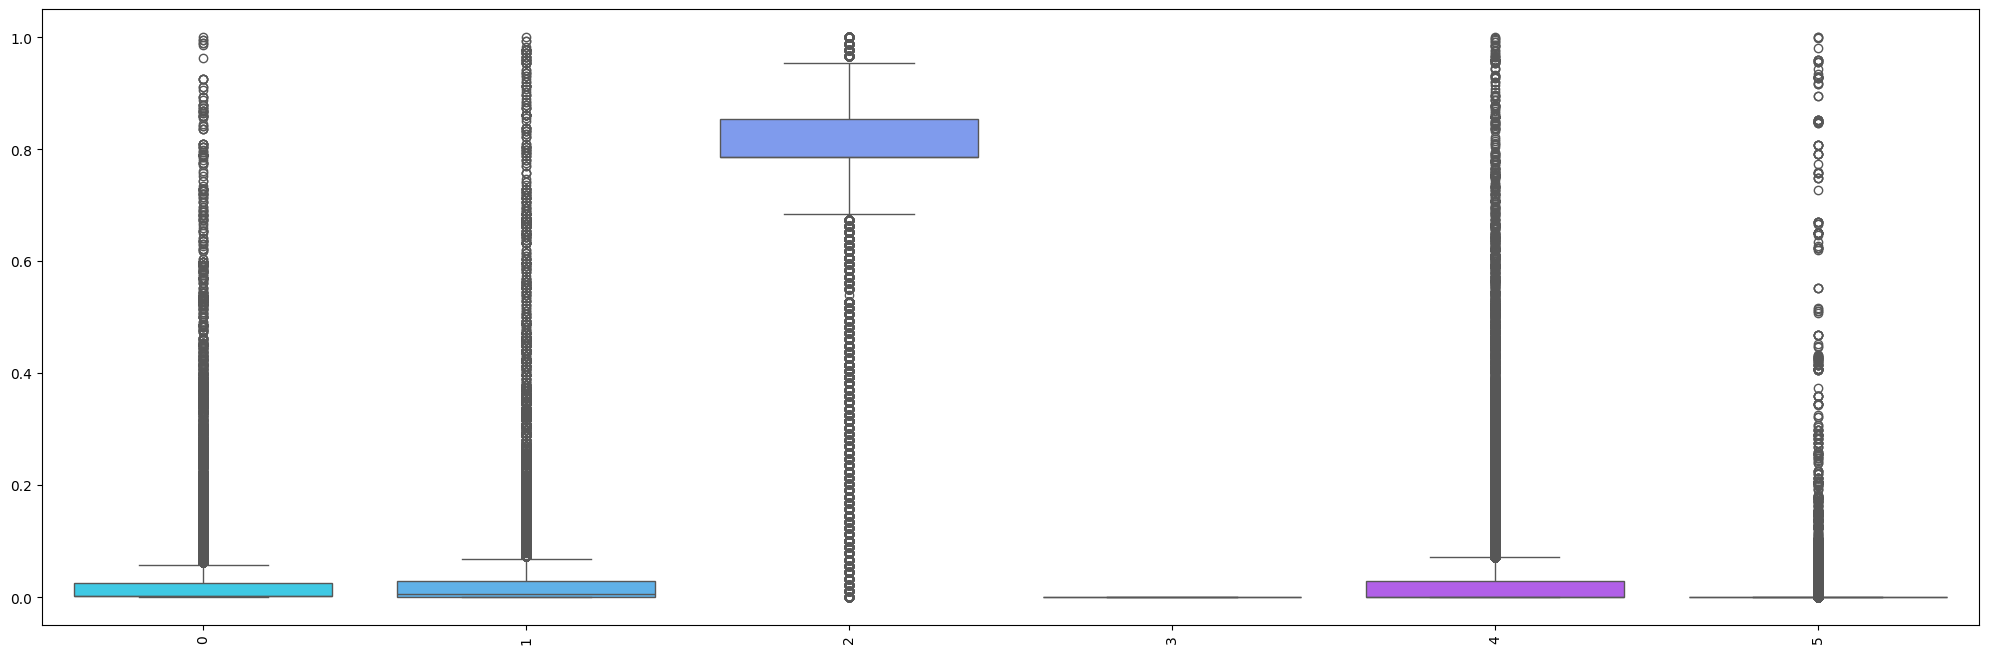

In [25]:
#isolate + clean features
features = [
    'spkts','dpkts', 'proto', 'is_ftp_login', 'dur', 'response_body_len']

train_encoded = train[features]
label_encoders = {}
for column in train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))
    label_encoders[column] = le

test_encoded = test[features]
for column in test_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    test_encoded[column] = le.fit_transform(test_encoded[column].astype(str))
    label_encoders[column] = le

X_train = train_encoded
X_test =  test_encoded

y_train = train['label']
y_test = test['label']

print(y_train.shape)

# Apply Z-score filter on X_train
z_scores_train = np.abs(stats.zscore(X_train))
train_mask = (z_scores_train < 3).all(axis=1)
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]  # no .iloc or .values

# Apply Z-score filter on X_test
z_scores_test = np.abs(stats.zscore(X_test))
test_mask = (z_scores_test < 3).all(axis=1)
X_test_filtered = X_test[test_mask]
y_test_filtered =  y_test[test_mask]  # no .iloc or .values


#Aggressively scale standardise data for fairness
ro_scaler = RobustScaler()
scaler = MinMaxScaler()

X_train_filtered = ro_scaler.fit_transform(X_train_filtered)
X_test_filtered = ro_scaler.fit_transform(X_test_filtered)

X_train_filtered = pd.DataFrame(scaler.fit_transform(X_train_filtered))
X_test_filtered = pd.DataFrame(scaler.fit_transform(X_test_filtered))

plt.figure(figsize = (25,8))
u = sns.boxplot(palette = 'cool', data=X_train_filtered)
u.set_xticklabels(u.get_xticklabels(),rotation=90)


In [22]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', MLPClassifier(max_iter=300, random_state=42))])

param_dist = {'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)], 
              'mlp__activation': ['relu', 'tanh'], 
              'mlp__alpha': [0.0001, 0.01],
              'mlp__solver': ['sgd', 'adam'],
              }
search = RandomizedSearchCV(pipeline, 
                            param_distributions=param_dist,  
                            cv=3, 
                            n_iter= 50,
                            scoring='accuracy', 
                            verbose=2, 
                            n_jobs=-1)

X_sample = X_train_filtered.sample(5000, random_state=42)
y_sample = y_train_filtered.sample(5000, random_state=42)

search.fit(X_sample, y_sample)

print("Best Accuracy:", search.best_score_)
print("Best Params:", search.best_params_)


C:\Users\zalak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\zalak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Accuracy: 0.9130004731346647
Best Params: {'mlp__solver': 'adam', 'mlp__hidden_layer_sizes': (50, 50), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}


In [28]:
# mlp
pipeline = Pipeline([('scaler', StandardScaler()),('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300,random_state=42))])

pipeline.fit(X_train, y_train)
y_pred_mlp = pipeline.predict(X_test)  
acc = accuracy_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp, average='weighted')

print("\nClassification Report for using MLP: \n", classification_report(y_test, y_pred_mlp, digits=4, zero_division=0))

# cm_mlp = confusion_matrix(y_test, y_pred_mlp)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
# disp.plot(cmap='Blues', xticks_rotation=45)
# plt.title("MLP Confusion Matrix")
# plt.show()



C:\Users\zalak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Classification Report for using MLP: 
               precision    recall  f1-score   support

           0     0.9818    0.4143    0.5827     37000
           1     0.6752    0.9937    0.8041     45332

    accuracy                         0.7333     82332
   macro avg     0.8285    0.7040    0.6934     82332
weighted avg     0.8130    0.7333    0.7046     82332



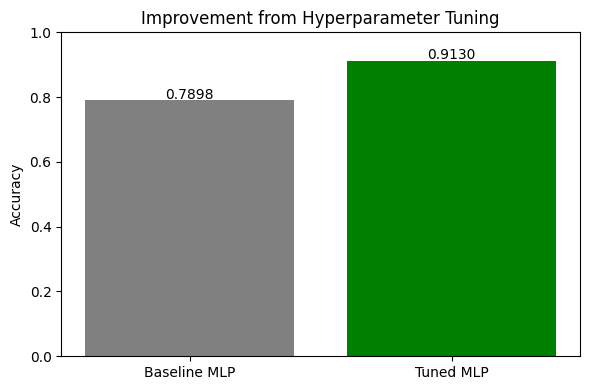

In [ ]:
baseline_accuracy = accuracy_score(y_test, y_pred_mlp)
tuned_accuracy = search.best_score_
plt.figure(figsize=(6, 4))
bars = plt.bar(["Baseline MLP", "Tuned MLP"], [baseline_accuracy, tuned_accuracy], color=["grey", "green"])
plt.ylabel("Accuracy")
plt.title("Improvement from Hyperparameter Tuning")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.4f}', ha='center')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
